<a href="https://colab.research.google.com/github/joomj2000/DeepLearning/blob/main/LeNet_catndog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipywidgets
from ipywidgets import FloatProgress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [5]:
cat_directory = r'/content/drive/MyDrive/skt_deep_learning/data/dogs-vs-cats/Cat/'
dog_directory = r'/content/drive/MyDrive/skt_deep_learning/data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None] #안열리는 파일을 버리기 ** - 매우 중요

random.seed(42)
random.shuffle(correct_images_filepaths)
print(len(correct_images_filepaths))
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 함
train_images_filepaths = correct_images_filepaths[:5000]
val_images_filepaths = correct_images_filepaths[5000:5100]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

8007
5000 100 10


In [6]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

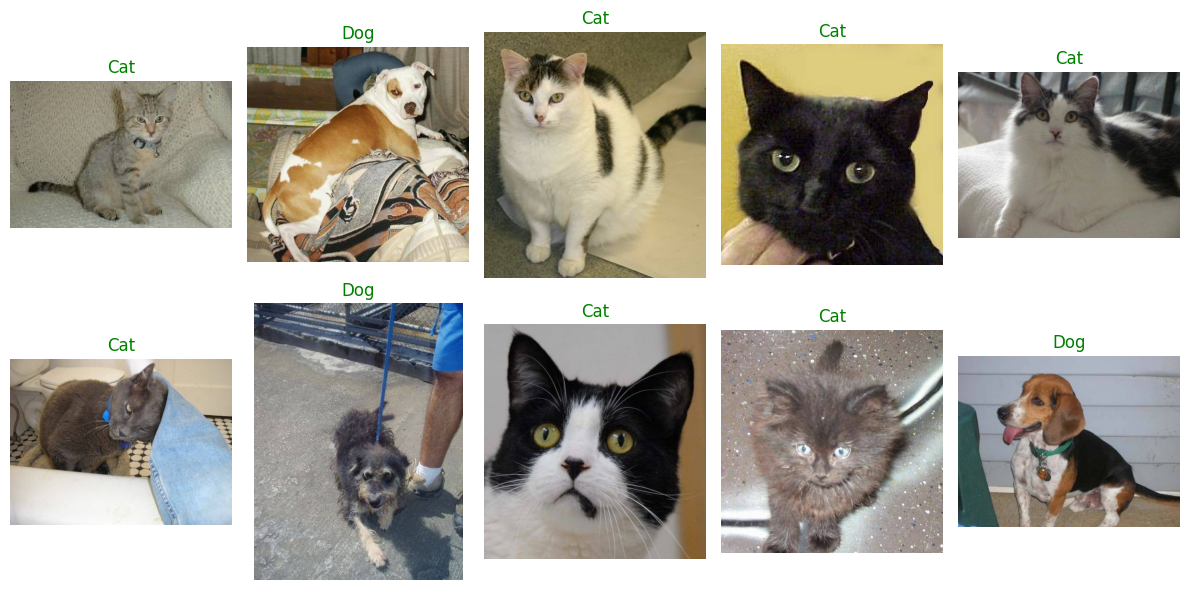

In [7]:
display_image_grid(test_images_filepaths)

In [8]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [9]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [10]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0])


In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out1 = self.cnn1(x)
        out2 = self.relu1(out1)
        out3 = self.maxpool1(out2)
        out4 = self.cnn2(out3)
        out5 = self.relu2(out4)
        out6 = self.maxpool2(out5)
        out7 = out6.view(out6.size(0), -1)
        out8 = self.fc1(out7)
        out9 = self.fc2(out8)
        out = self.output(out9)
        return out

In [13]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [14]:
from torchsummary import summary
summary(model.cuda(), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [17]:
model = model.to(device)
criterion = criterion.to(device)

In [18]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred_prob, preds = torch.max(outputs, 1) # 예측확률, 예측정답
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [19]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-18-34783c89d4b4>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6792 Acc: 0.5660


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6485 Acc: 0.6800
Epoch 2/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6563 Acc: 0.6124


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6671 Acc: 0.5700
Epoch 3/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6442 Acc: 0.6328


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6446 Acc: 0.6500
Epoch 4/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6372 Acc: 0.6452


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6386 Acc: 0.6200
Epoch 5/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6286 Acc: 0.6542


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6494 Acc: 0.6000
Epoch 6/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6258 Acc: 0.6552


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6383 Acc: 0.6200
Epoch 7/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6177 Acc: 0.6694


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6605 Acc: 0.5800
Epoch 8/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6080 Acc: 0.6872


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6318 Acc: 0.6400
Epoch 9/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6030 Acc: 0.6884


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6434 Acc: 0.6000
Epoch 10/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6023 Acc: 0.6874


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6151 Acc: 0.6300
Training complete in 7m 10s
Best val Acc: 0.680000


In [20]:
def test(model, test_images_filepaths):
    id_list = []
    pred_list = []
    _id=0
    with torch.no_grad():
        for test_path in tqdm(test_images_filepaths):
            img = Image.open(test_path)
            _id =test_path.split('/')[-1].split('.')[1]
            transform = ImageTransform(size, mean, std)
            img = transform(img, phase='val') #val로 설정하면 랜덤 주지 않음
            img = img.unsqueeze(0) #배치가 1인것을 추가해줌 (토치는 패치단위로 학습하도록 되어있으므로 첫번째에 무조건 배치사이즈가 들어가야함)
            #unsqueeze는 해당자리에 1을 넣어줌 현재는 0에 넣었으므로 맨 앞에 배치사이즈를 추가함
            img = img.to(device)

            model.eval()
            outputs = model(img)
            #preds = F.softmax(outputs, dim=1)[:, 1].tolist()
            preds, pred_ans = torch.max(outputs, 1)
            id_list.append(_id)
            pred_list.append(pred_ans.cpu().item())
    return id_list, pred_list



In [22]:
import pandas as pd

id_list, pred_list = test(model, test_images_filepaths)

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/skt_deep_learning/data/dogs-vs-cats/LesNet.csv', index=False)

<ipython-input-20-92e80c2bba96>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

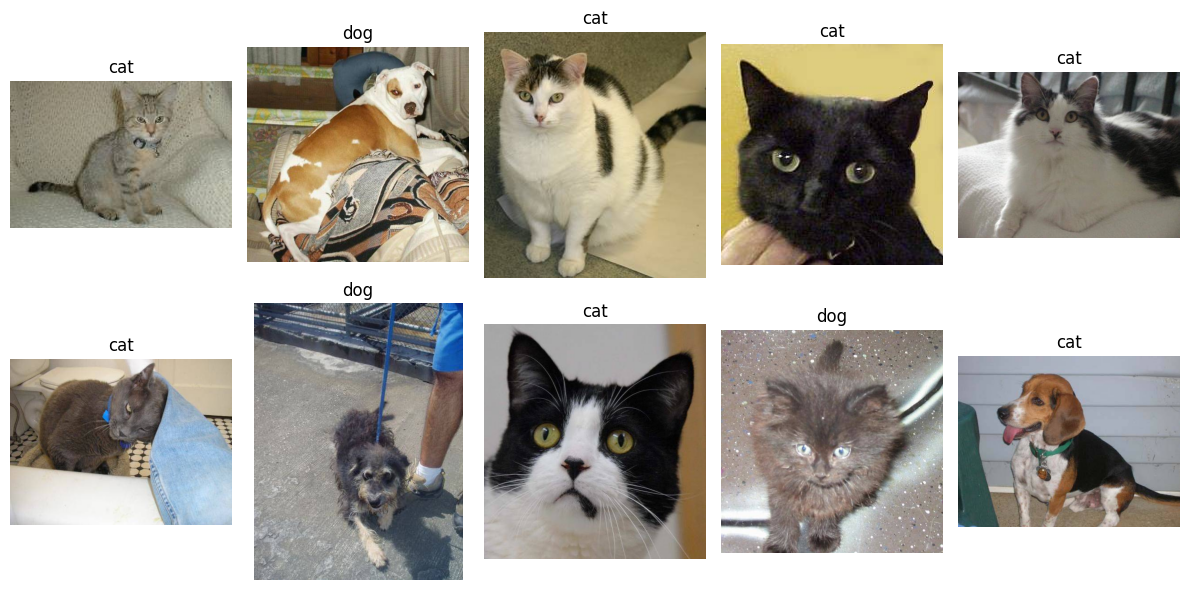

In [24]:
display_image_grid(test_images_filepaths)

# AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model = AlexNet()
model.to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

In [ ]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

In [ ]:
import pandas as pd

id_list, pred_list = test(model, test_images_filepaths)

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/skt_deep_learning/data/dogs-vs-cats/alexnet.csv', index=False)

In [ ]:
display_image_grid(test_images_filepaths)

#VGGNet

In [25]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)  # 필터와 스트라이드 알아서 조정! output만 설정하면됨
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [26]:
# 명세서 같은 느낌
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'] #8(합성곱층)+3(풀링층)=11(전체계층)
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512,
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']

In [27]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c

    return nn.Sequential(*layers)

In [28]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

In [29]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [30]:
OUTPUT_DIM = 2
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [31]:
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [32]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-18-34783c89d4b4>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6938 Acc: 0.5292


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6839 Acc: 0.5600
Epoch 2/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6880 Acc: 0.5422


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6767 Acc: 0.5600
Epoch 3/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6827 Acc: 0.5576


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6707 Acc: 0.5500
Epoch 4/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6757 Acc: 0.5730


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6676 Acc: 0.5500
Epoch 5/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6753 Acc: 0.5820


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6631 Acc: 0.5600
Epoch 6/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6686 Acc: 0.5906


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6612 Acc: 0.5600
Epoch 7/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6667 Acc: 0.5972


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6595 Acc: 0.5600
Epoch 8/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6650 Acc: 0.5990


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6558 Acc: 0.5600
Epoch 9/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6598 Acc: 0.6094


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6543 Acc: 0.5600
Epoch 10/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6586 Acc: 0.6060


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6539 Acc: 0.5600
Training complete in 13m 20s
Best val Acc: 0.560000


<ipython-input-20-92e80c2bba96>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

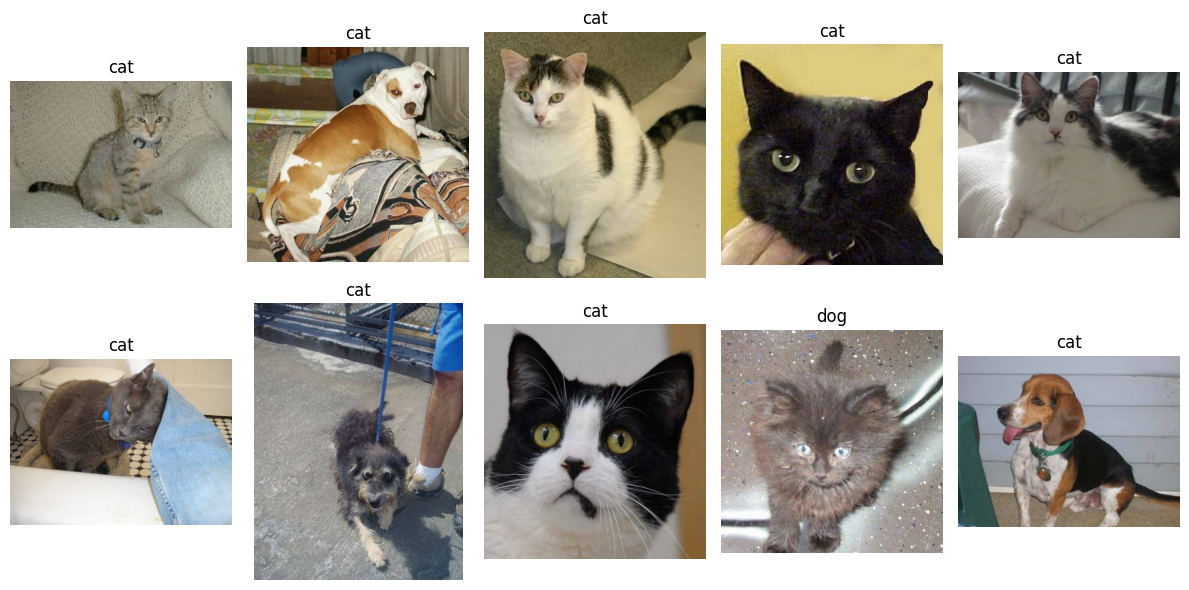

In [33]:
id_list, pred_list = test(model, test_images_filepaths)

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/skt_deep_learning/data/dogs-vs-cats/vggnet.csv', index=False)

display_image_grid(test_images_filepaths)

In [34]:
vgg19_layers = get_vgg_layers(vgg19_config, batch_norm = True)

In [40]:
OUTPUT_DIM = 2
model2 = VGG(vgg19_layers, OUTPUT_DIM)
print(model2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [36]:
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model2 = model2.to(device)
criterion = criterion.to(device)

In [37]:
num_epoch = 10
model2 = train_model(model2, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-18-34783c89d4b4>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.7025 Acc: 0.5038


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6891 Acc: 0.5100
Epoch 2/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.7026 Acc: 0.5026


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6872 Acc: 0.5100
Epoch 3/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6976 Acc: 0.5126


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6890 Acc: 0.5300
Epoch 4/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.7022 Acc: 0.5000


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6918 Acc: 0.5000
Epoch 5/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6997 Acc: 0.4964


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6911 Acc: 0.5200
Epoch 6/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6965 Acc: 0.5068


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6870 Acc: 0.4900
Epoch 7/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.7008 Acc: 0.4988


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6891 Acc: 0.4800
Epoch 8/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.6999 Acc: 0.4984


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6896 Acc: 0.5100
Epoch 9/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.7029 Acc: 0.4934


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6897 Acc: 0.5000
Epoch 10/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.7008 Acc: 0.5012


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6872 Acc: 0.5000
Training complete in 20m 59s
Best val Acc: 0.530000


<ipython-input-20-92e80c2bba96>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

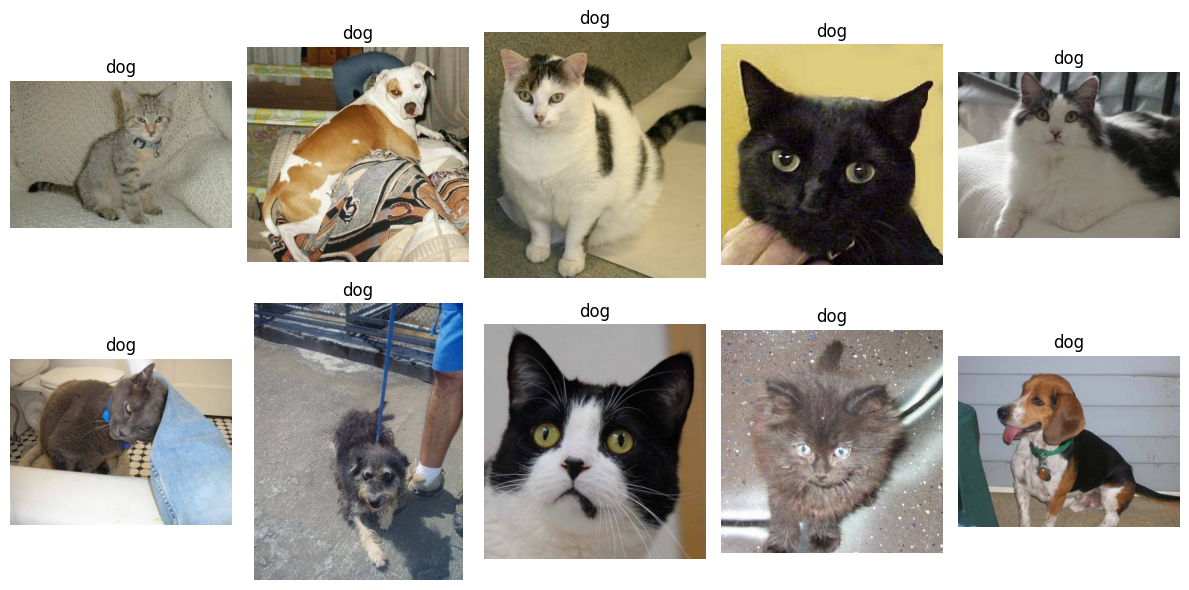

In [39]:
id_list, pred_list = test(model2, test_images_filepaths)

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/skt_deep_learning/data/dogs-vs-cats/vggnet19.csv', index=False)

display_image_grid(test_images_filepaths)

#pretrained model 사용

In [42]:
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained = True).cuda()
print(pretrained_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:07<00:00, 73.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [45]:

num_epoch = 10

for param in pretrained_model.parameters():# 특징추출을 위해 requires_grad 끄기
    param.requires_grad = False

pretrained_model.classifier[-1] = torch.nn.Linear(4096, 2).cuda()

#현재는 데이터가 적기 때문에 finetuning방식보다 특징 추출 방식이 성능이 더 잘나옴!
#optimizer = optim.Adam(pretrained_model.parameters(), lr = 1e-3) # 모든 파라미터를 조정하는 finetuning방식!
optimizer = optim.Adam(pretrained_model.classifier[-1].parameters(), lr = 1e-3) # 마지막 레이어만 바꾸는 특징추출 방식 (위에 requries_grad를 안써도 되긴함)
criterion = nn.CrossEntropyLoss()
model = train_model(pretrained_model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-18-34783c89d4b4>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.1111 Acc: 0.9584


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0538 Acc: 1.0000
Epoch 2/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0749 Acc: 0.9708


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0432 Acc: 0.9800
Epoch 3/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0675 Acc: 0.9714


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0484 Acc: 0.9900
Epoch 4/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0732 Acc: 0.9702


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0352 Acc: 1.0000
Epoch 5/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0752 Acc: 0.9706


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0625 Acc: 0.9500
Epoch 6/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0672 Acc: 0.9744


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0477 Acc: 0.9700
Epoch 7/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0718 Acc: 0.9744


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0539 Acc: 0.9700
Epoch 8/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0691 Acc: 0.9730


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0773 Acc: 0.9600
Epoch 9/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0690 Acc: 0.9726


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0331 Acc: 1.0000
Epoch 10/10
--------------------


  0%|          | 0/157 [00:00<?, ?it/s]

train Loss: 0.0721 Acc: 0.9746


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0711 Acc: 0.9600
Training complete in 8m 6s
Best val Acc: 1.000000


In [ ]:
import pandas as pd

id_list, pred_list = test(model, test_images_filepaths)

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/skt_deep_learning/data/dogs-vs-cats/vggnet_pretrained.csv', index=False)

display_image_grid(test_images_filepaths)